# Traffic collisions are not yet updated with 2022 Q4 data
- still NEIGHBORHOOD_140, not NEIGHBORHOOD_158

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import requests
from bs4 import BeautifulSoup
import re
import geopy # https://github.com/shakasom/geocoding/blob/master/geocoding.ipynb
from geopy.geocoders import Nominatim
import json
import geopy.distance
import numpy as np
import itertools
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import tabula
import datetime as dt

In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [3]:
# Projected Coordinate System (PCS): how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System (GCS): how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import traffic collisions data
- about and documentation https://data.torontopolice.on.ca/datasets/TorontoPS::traffic-collisions-asr-t-tbl-001/about

In [4]:
neighbourhoods = gpd.read_file('../data/processed/neighbourhoods.geojson')

In [10]:
collision_df = pd.read_parquet('../data/raw/traffic_collisions.parquet')
# collision_df.drop(columns=['x','y'], inplace=True)
collision_df

,OBJECTID,EVENT_UNIQUE_ID,OCC_DATE,OCC_MONTH,OCC_DOW,OCC_YEAR,OCC_HOUR,DIVISION,HOOD_158,NEIGHBOURHOOD_158,Fatalities,Injury_Collisions,FTR_Collisions,PD_Collisions,LONGITUDE,LATITUDE,ObjectId2,SHAPE
0,401,GO-20148000204,2014-01-03 05:00:00,January,Friday,2014,8,NSA,NSA,NSA,0,NO,NO,YES,0.0,0.0,1,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00...
1,402,GO-20148000205,2014-01-03 05:00:00,January,Friday,2014,12,D54/D55,68,North Riverdale (68),0,NO,NO,YES,-79.353893,43.670491,2,b'\x01\x01\x00\x00\x00\xb0\xcb\xe8.\xa6\xd6S\x...
2,403,GO-20148000206,2014-01-03 05:00:00,January,Friday,2014,8,NSA,NSA,NSA,0,NO,NO,YES,0.0,0.0,3,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00...
3,404,GO-20148000208,2014-01-03 05:00:00,January,Friday,2014,11,D52,79,University (79),0,NO,NO,YES,-79.40207,43.663052,4,b'\x01\x01\x00\x00\x00\x05\xb9Q\x85\xbb\xd9S\x...
4,405,GO-20148000209,2014-01-03 05:00:00,January,Friday,2014,13,D32,50,Newtonbrook East (50),0,NO,NO,YES,-79.420043,43.798,5,b'\x01\x01\x00\x00\x00W\xc1\x1c\xfb\xe1\xdaS\x...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553775,553220,GO-20228022848,2022-06-27 04:00:00,June,Monday,2022,17,D41,126,Dorset Park (126),0,NO,NO,YES,-79.284796,43.747518,553776,b'\x01\x01\x00\x00\x00\x9cA\xd7\x19:\xd2S\xc0\...
553776,553221,GO-20228022849,2022-06-27 04:00:00,June,Monday,2022,7,D13,92,Corso Italia-Davenport (92),0,YES,NO,NO,-79.443043,43.677962,553777,b'\x01\x01\x00\x00\x00\xec\x1e\x8f\xcfZ\xdcS\x...
553777,553222,GO-20228022856,2022-06-27 04:00:00,June,Monday,2022,23,D41,123,Cliffcrest (123),0,NO,NO,YES,-79.235346,43.707215,553778,b'\x01\x01\x00\x00\x00?UC\xea\x0f\xcfS\xc0\x08...
553778,553223,GO-20228022858,2022-06-27 04:00:00,June,Monday,2022,18,D53,99,Mount Pleasant East (99),0,NO,NO,YES,-79.376298,43.708705,553779,b'\x01\x01\x00\x00\x001\x9dsC\x15\xd8S\xc0T\xa...


In [6]:
collision_df.OCC_DATE.max()

Timestamp('2022-06-30 04:00:00')

In [7]:
collision_df.shape

(553780, 18)

## No missing data

In [8]:
print("Columns with missing data")
collision_df.isna().sum()[collision_df.isna().sum() != 0]

Columns with missing data


Series([], dtype: int64)

## Split hood_id from neighbourhood

In [14]:
collision_df['NEIGHBOURHOOD_158'] = collision_df['NEIGHBOURHOOD_158'].str.split('(', expand=True)[0]

In [15]:
# check that every NSA in hood_id is NSA in neighbourhood
# should only show "NSA" as the only unique entry
collision_df[collision_df['HOOD_158'] == "NSA"]['NEIGHBOURHOOD_158'].unique()

<StringArray>
['NSA']
Length: 1, dtype: string

In [16]:
# should only show "NSA" as the only unique entry
collision_df[collision_df['NEIGHBOURHOOD_158'] == "NSA"]['HOOD_158'].unique()

<StringArray>
['NSA', '531']
Length: 2, dtype: string

In [17]:
# fix the neighbourhood for hood_id = 531
collision_df.loc[(collision_df.HOOD_158 == '531') & (collision_df.NEIGHBOURHOOD_158 == 'NSA'), "HOOD_158"] = "NSA"

In [18]:
mci_select = pd.read_csv('../data/processed/mci_select.csv')

In [20]:
# keep the format consistent with major crime indicators
collision_df.drop(columns=['OBJECTID', 'ObjectId2', 'SHAPE'], inplace=True)
pd.concat([collision_df.iloc[0,:], mci_select.iloc[0,:]], axis=1)

,0,0
EVENT_UNIQUE_ID,GO-20148000204,GO-20141260701
OCC_DATE,2014-01-03 05:00:00,2014-01-01 05:00:00
OCC_MONTH,January,January
OCC_DOW,Friday,Wednesday
OCC_YEAR,2014,2014
OCC_HOUR,8,NaN
DIVISION,NSA,D51
HOOD_158,NSA,70
NEIGHBOURHOOD_158,NSA,South Riverdale
Fatalities,0,NaN


In [22]:
collision_df['OCC_DAY'] = collision_df['OCC_DATE'].dt.day.astype(int)
collision_df['OCC_DOY'] = collision_df['OCC_DATE'].dt.dayofyear.astype(int)

In [23]:
# now columns are similar to mci_select
pd.concat([collision_df.iloc[0,:], mci_select.iloc[0,:]], axis=1)

,0,0
EVENT_UNIQUE_ID,GO-20148000204,GO-20141260701
OCC_DATE,2014-01-03 05:00:00,2014-01-01 05:00:00
OCC_MONTH,January,January
OCC_DOW,Friday,Wednesday
OCC_YEAR,2014,2014
OCC_HOUR,8,NaN
DIVISION,NSA,D51
HOOD_158,NSA,70
NEIGHBOURHOOD_158,NSA,South Riverdale
Fatalities,0,NaN


## Checking for inconsistencies

### inconsistency in hour of day

In [25]:
# is the year, month, day etc. consistent with the date column?
print(sum(collision_df.OCC_DATE.dt.year != collision_df.OCC_YEAR))
print(sum(collision_df.OCC_DATE.dt.strftime("%B") != collision_df.OCC_MONTH))
print(sum(collision_df.OCC_DATE.dt.day.astype(float) != collision_df.OCC_DAY))
print(sum(collision_df.OCC_DATE.dt.dayofyear.astype(float) != collision_df.OCC_DOY))
print(sum(collision_df.OCC_DATE.dt.strftime("%A") != collision_df.OCC_DOW))
print(sum(collision_df.OCC_DATE.dt.hour != collision_df.OCC_HOUR))

0
0
0
0
0
549628


In [26]:
# occurencehour looks incorrect
collision_df.loc[collision_df.OCC_DATE.dt.hour != collision_df.OCC_HOUR, ['OCC_DATE', 'OCC_HOUR']]

,OCC_DATE,OCC_HOUR
0,2014-01-03 05:00:00,8
1,2014-01-03 05:00:00,12
2,2014-01-03 05:00:00,8
3,2014-01-03 05:00:00,11
4,2014-01-03 05:00:00,13
...,...,...
553775,2022-06-27 04:00:00,17
553776,2022-06-27 04:00:00,7
553777,2022-06-27 04:00:00,23
553778,2022-06-27 04:00:00,18


In [27]:
# this does not make sense
collision_df.OCC_DATE.dt.hour.describe()

count    553780.000000
mean          4.370542
std           0.482950
min           4.000000
25%           4.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: OCC_DATE, dtype: float64

In [28]:
# this makes more sense that traffic collisions happen throughout the day
collision_df.OCC_HOUR.describe()

count     553780.0
mean     13.466469
std       4.933017
min            0.0
25%           10.0
50%           14.0
75%           17.0
max           23.0
Name: OCC_HOUR, dtype: Float64

In [29]:
print("before fixing:", collision_df['OCC_DATE'][0])
print("after fixing:", collision_df['OCC_DATE'][0].replace(hour=int(collision_df['OCC_HOUR'][0])))

before fixing: 2014-01-03 05:00:00
after fixing: 2014-01-03 08:00:00


In [30]:
dates = []
for date, hour in zip(collision_df.OCC_DATE, collision_df.OCC_HOUR):
    dates.append(date.replace(hour=int(hour)))

In [31]:
collision_df['OCC_DATE'] = dates

### inconsistency in hood_ID and neighbourhood

In [34]:
# check if hood_id and neighbourhood are 1-to-1
# number of unique values in hood_id and neighbourhood should be the same
print(len(collision_df.HOOD_158.unique()), len(collision_df.NEIGHBOURHOOD_158.unique()))

141 141


In [35]:
check_duplicate = collision_df.groupby(['HOOD_158','NEIGHBOURHOOD_158']).size().reset_index(name='counts')

In [36]:
# duplicates in hood_id since some record are of int type, while some are strings
check_duplicate[check_duplicate.duplicated(subset='NEIGHBOURHOOD_158', keep=False)].sort_values(by='NEIGHBOURHOOD_158')

,HOOD_158,NEIGHBOURHOOD_158,counts


In [37]:
# duplicate neighbourhood values due to white space
check_duplicate[check_duplicate.duplicated(subset='HOOD_158', keep=False)].sort_values(by='HOOD_158')[:2].values

array([], shape=(0, 3), dtype=object)

In [39]:
collision_df['NEIGHBOURHOOD_158'] = collision_df['NEIGHBOURHOOD_158'].str.strip()

In [40]:
# no more duplicates due to white space but not have 2 due to format issues
check_duplicate = collision_df.groupby(['HOOD_158','NEIGHBOURHOOD_158']).size().reset_index(name='counts')
check_duplicate[check_duplicate.duplicated(subset='HOOD_158', keep=False)].sort_values(by='HOOD_158')

,HOOD_158,NEIGHBOURHOOD_158,counts


In [104]:
# fix duplicate neighbourhood
# collision_df.loc[(collision_df.hood_id == '117') & (collision_df.neighbourhood == 'LAmoreaux'), 'neighbourhood'] = "L'Amoreaux"
# collision_df.loc[(collision_df.hood_id == '118') & (collision_df.neighbourhood == 'Tam OShanter-Sullivan'), 'neighbourhood'] = "Tam O'Shanter-Sullivan"

In [105]:
# no more duplicates
# check_duplicate = collision_df.groupby(['hood_id','neighbourhood']).size().reset_index(name='counts')
# check_duplicate[check_duplicate.duplicated(subset='hood_id', keep=False)].sort_values(by='hood_id')

In [41]:
check_duplicate[check_duplicate.duplicated(subset='NEIGHBOURHOOD_158', keep=False)].sort_values(by='NEIGHBOURHOOD_158')

,HOOD_158,NEIGHBOURHOOD_158,counts


### inconsistency vs neighbourhood boundary

In [46]:
merge_df = pd.merge(neighbourhoods[['NEIGHBOURHOOD', 'HOOD_ID']], collision_df[['HOOD_158', 'NEIGHBOURHOOD_158']], left_on=['HOOD_ID'], right_on = ['HOOD_158'], how='outer', suffixes=('_neighbourhood', '_collision'))
merge_df[merge_df['NEIGHBOURHOOD'] != merge_df['NEIGHBOURHOOD_158']].drop_duplicates(subset=['NEIGHBOURHOOD'])

,NEIGHBOURHOOD,HOOD_ID,HOOD_158,NEIGHBOURHOOD_158
456810,Tam O'Shanter-Sullivan,118,118,Tam OShanter-Sullivan
2403620,O'Connor-Parkview,54,54,OConnor-Parkview
3311640,Weston-Pelham Park,91,91,Weston-Pellam Park


In [62]:
collision_df.loc[(collision_df.HOOD_158 == '118') & (collision_df.NEIGHBOURHOOD_158 == 'Tam OShanter-Sullivan'), 'NEIGHBOURHOOD_158'] = "Tam O'Shanter-Sullivan"
collision_df.loc[(collision_df.HOOD_158 == '54') & (collision_df.NEIGHBOURHOOD_158 == 'OConnor-Parkview'), 'NEIGHBOURHOOD_158'] = "O'Connor-Parkview"
collision_df.loc[(collision_df.HOOD_158 == '117') & (collision_df.NEIGHBOURHOOD_158 == 'LAmoreaux'), 'NEIGHBOURHOOD_158'] = "L'Amoreaux"
collision_df.loc[(collision_df.HOOD_158 == '91') & (collision_df.NEIGHBOURHOOD_158 == 'Weston-Pellam Park'), 'NEIGHBOURHOOD_158'] = "Weston-Pelham Park"

In [63]:
# now neighbourhoods are consistent
merge_df = pd.merge(neighbourhoods[['NEIGHBOURHOOD', 'HOOD_ID']], collision_df[['HOOD_158', 'NEIGHBOURHOOD_158']], left_on=['HOOD_ID'], right_on = ['HOOD_158'], how='outer', suffixes=('_neighbourhood', '_collision'))
merge_df[merge_df['NEIGHBOURHOOD'] != merge_df['NEIGHBOURHOOD_158']].drop_duplicates(subset=['NEIGHBOURHOOD']).values

array([], shape=(0, 4), dtype=object)

## Fixing data types

In [66]:
collision_df.Injury_Collisions.value_counts()

Injury_Collisions
NO     478927
YES     74853
Name: count, dtype: Int64

In [69]:
mapping = {'YES': '1', 'NO': '0'}
collision_df.replace({'Injury_Collisions': mapping,
                      'FTR_Collisions': mapping,
                      'PD_Collisions': mapping}, inplace=True)

## Impute missing long and lat

In [71]:
collision_df.loc[(collision_df['LONGITUDE'] == 0) & (collision_df['LATITUDE'] == 0), ["NEIGHBOURHOOD_158"]].value_counts()

NEIGHBOURHOOD_158                
NSA                                  77945
Wexford/Maryvale                        83
West Hill                               34
Kennedy Park                            23
Yorkdale-Glen Park                      16
Hillcrest Village                       13
L'Amoreaux                              12
Glenfield-Jane Heights                  11
Clairlea-Birchmount                     10
York University Heights                  8
Islington-City Centre West               8
Bendale                                  7
Highland Creek                           7
Agincourt South-Malvern West             6
Black Creek                              6
Bay Street Corridor                      3
West Humber-Clairville                   3
Bayview Woods-Steeles                    3
Pelmo Park-Humberlea                     2
Bathurst Manor                           2
Church-Yonge Corridor                    2
Westminster-Branson                      2
High Park North     

In [72]:
# We can only estimate the location for those crimes with a neighbourhood associated to them 
# Drow rows without information about location and associated neighbourhood
collision_df = collision_df[~((collision_df['LONGITUDE'] == 0) & (collision_df['LATITUDE'] == 0) & (collision_df['NEIGHBOURHOOD_158'] == "NSA"))].reset_index(drop=True)

In [73]:
missing_location = collision_df.loc[(collision_df['LONGITUDE'] == 0) & (collision_df['LATITUDE'] == 0)].index
collision_df.loc[missing_location]

,EVENT_UNIQUE_ID,OCC_DATE,OCC_MONTH,OCC_DOW,OCC_YEAR,OCC_HOUR,DIVISION,HOOD_158,NEIGHBOURHOOD_158,Fatalities,Injury_Collisions,FTR_Collisions,PD_Collisions,LONGITUDE,LATITUDE,OCC_DAY,OCC_DOY
8656,GO-20141591056,2014-02-24 17:00:00,February,Monday,2014,17,D32,40,St.Andrew-Windfields,0,0,1,0,0.0,0.0,24,55
42720,GO-20143120578,2014-10-17 09:00:00,October,Friday,2014,9,D31,25,Glenfield-Jane Heights,0,0,0,1,0.0,0.0,17,290
173414,GO-20168053844,2016-11-30 18:00:00,November,Wednesday,2016,18,D33,48,Hillcrest Village,0,0,0,1,0.0,0.0,30,335
175194,GO-20168055402,2016-12-10 12:00:00,December,Saturday,2016,12,D41,119,Wexford/Maryvale,0,0,0,1,0.0,0.0,10,345
176577,GO-20168056919,2016-12-17 09:00:00,December,Saturday,2016,9,D31,27,York University Heights,0,0,0,1,0.0,0.0,17,352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470633,GO-20228018314,2022-05-27 16:00:00,May,Friday,2022,16,D41,124,Kennedy Park,0,0,1,1,0.0,0.0,27,147
470881,GO-20228017965,2022-05-23 15:00:00,May,Monday,2022,15,D41,120,Clairlea-Birchmount,0,0,0,1,0.0,0.0,23,143
472195,GO-20228019271,2022-06-03 14:00:00,June,Friday,2022,14,D41,119,Wexford/Maryvale,0,0,0,1,0.0,0.0,3,154
472730,GO-20228020678,2022-06-14 11:00:00,June,Tuesday,2022,11,D43,134,Highland Creek,0,0,1,0,0.0,0.0,14,165


In [76]:
missing_count = collision_df.loc[missing_location]['HOOD_158'].value_counts()
missing_count = missing_count.reset_index(drop=False)
missing_count

,HOOD_158,count
0,119,83
1,136,34
2,124,23
3,31,16
4,48,13
5,117,12
6,25,11
7,120,10
8,14,8
9,27,8


### Generate random points within neighbourhood

In [87]:
neighbourhoods.loc[neighbourhoods['HOOD_ID'] == '117', 'geometry'].unique().bounds.flatten().tolist()

[]

In [90]:
# randomly generate points within a defined neighbourhood
# https://gis.stackexchange.com/questions/207731/generating-random-coordinates-in-multipolygon-in-python
def generate_random(number, HOOD_ID):
    try:
        selected_neighbourhood = neighbourhoods.loc[neighbourhoods['HOOD_ID'] == str(HOOD_ID)]
        polygon = selected_neighbourhood['geometry']
        points_x = []
        points_y = []
        count = 0
        try: 
            minx, miny, maxx, maxy = polygon.unique().bounds.flatten().tolist()
        except ValueError:
            print(selected_neighbourhood)
            print(f"No geometry for {HOOD_ID}")
        while len(points_x) < number:
            pnt = shapely.geometry.Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
            if polygon.contains(pnt).values[0]:
                points_x.append(pnt.x)
                points_y.append(pnt.y)
            count += 1
        print(f"{count} points generated but only include the {len(points_x)} points within the neighbourhood")
        return pd.Series([points_x, points_y])
    except:
        return pd.Series([np.nan, np.nan])

In [91]:
np.random.seed(123)
missing_count[['LONGITUDE', 'LATITUDE']] = missing_count.apply(lambda x: generate_random(x['count'],x['HOOD_158']), axis=1)

120 points generated but only include the 83 points within the neighbourhood
59 points generated but only include the 34 points within the neighbourhood
38 points generated but only include the 23 points within the neighbourhood
20 points generated but only include the 16 points within the neighbourhood
24 points generated but only include the 13 points within the neighbourhood
Empty GeoDataFrame
Columns: [NEIGHBOURHOOD, HOOD_ID, OCC_YEAR, distance_km, district, POP, area, geometry]
Index: []
No geometry for 117
15 points generated but only include the 11 points within the neighbourhood
19 points generated but only include the 10 points within the neighbourhood
Empty GeoDataFrame
Columns: [NEIGHBOURHOOD, HOOD_ID, OCC_YEAR, distance_km, district, POP, area, geometry]
Index: []
No geometry for 14
10 points generated but only include the 8 points within the neighbourhood
19 points generated but only include the 7 points within the neighbourhood
Empty GeoDataFrame
Columns: [NEIGHBOURHOOD, 

In [94]:
# random locations generated for each neighbourhood with missing long and lat values
missing_count.dropna(inplace=True)
missing_count['len'] = missing_count['LONGITUDE'].apply(lambda x: len(x))
missing_count

,HOOD_158,count,LONGITUDE,LATITUDE,len
0,119,83,"[-79.29059118869307, -79.31028443640116, -79.2...","[43.738460346598316, 43.75119240797253, 43.745...",83
1,136,34,"[-79.19826296051048, -79.19170980699191, -79.1...","[43.76650824127432, 43.766001245458526, 43.765...",34
2,124,23,"[-79.2571500311685, -79.25827609430044, -79.25...","[43.72237495041289, 43.71847917256988, 43.7190...",23
3,31,16,"[-79.45900706545015, -79.45129849864422, -79.4...","[43.7053044733809, 43.713114145582715, 43.7109...",16
4,48,13,"[-79.34424575279498, -79.36858767525977, -79.3...","[43.79591990189004, 43.80664608722862, 43.8074...",13
6,25,11,"[-79.52255193846452, -79.5251999448422, -79.50...","[43.74160663359397, 43.740569594102126, 43.747...",11
7,120,10,"[-79.27796149712432, -79.29732248019725, -79.2...","[43.72167701341969, 43.723729611522394, 43.714...",10
9,27,8,"[-79.49431178603646, -79.49798882556807, -79.4...","[43.76199928081355, 43.74798148117337, 43.7625...",8
10,134,7,"[-79.17535240192426, -79.17241355772417, -79.1...","[43.79942801241397, 43.79866824246465, 43.7926...",7
12,24,6,"[-79.52126554651844, -79.5266582950202, -79.52...","[43.76218017740331, 43.75697037640136, 43.7682...",6


In [95]:
# impute the missing long and lat values
for i in missing_count["HOOD_158"].unique():    
    index = (collision_df['HOOD_158'] == str(i)) & ((collision_df['LONGITUDE'] == 0) | (collision_df['LATITUDE'] == 0))
    collision_df.loc[index, ['LONGITUDE', 'LATITUDE']] = pd.DataFrame([np.where(collision_df.loc[index, 'LONGITUDE'] == 0, 
                                                                      missing_count[missing_count['HOOD_158'] == str(i)]['LONGITUDE'].iloc[0],
                                                                      collision_df.loc[index, 'LONGITUDE']),
                                                             np.where(collision_df.loc[index, 'LATITUDE'] == 0, 
                                                                      missing_count[missing_count['HOOD_158'] == str(i)]['LATITUDE'].iloc[0],
                                                                      collision_df.loc[index, 'LATITUDE'])]).T.values

In [96]:
# check missing long and lat values are now imputed
collision_df.loc[missing_location]

,EVENT_UNIQUE_ID,OCC_DATE,OCC_MONTH,OCC_DOW,OCC_YEAR,OCC_HOUR,DIVISION,HOOD_158,NEIGHBOURHOOD_158,Fatalities,Injury_Collisions,FTR_Collisions,PD_Collisions,LONGITUDE,LATITUDE,OCC_DAY,OCC_DOY
8656,GO-20141591056,2014-02-24 17:00:00,February,Monday,2014,17,D32,40,St.Andrew-Windfields,0,0,1,0,-79.380606,43.7578,24,55
42720,GO-20143120578,2014-10-17 09:00:00,October,Friday,2014,9,D31,25,Glenfield-Jane Heights,0,0,0,1,-79.522552,43.741607,17,290
173414,GO-20168053844,2016-11-30 18:00:00,November,Wednesday,2016,18,D33,48,Hillcrest Village,0,0,0,1,-79.344246,43.79592,30,335
175194,GO-20168055402,2016-12-10 12:00:00,December,Saturday,2016,12,D41,119,Wexford/Maryvale,0,0,0,1,-79.290591,43.73846,10,345
176577,GO-20168056919,2016-12-17 09:00:00,December,Saturday,2016,9,D31,27,York University Heights,0,0,0,1,-79.494312,43.761999,17,352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470633,GO-20228018314,2022-05-27 16:00:00,May,Friday,2022,16,D41,124,Kennedy Park,0,0,1,1,-79.26711,43.720285,27,147
470881,GO-20228017965,2022-05-23 15:00:00,May,Monday,2022,15,D41,120,Clairlea-Birchmount,0,0,0,1,-79.264308,43.704138,23,143
472195,GO-20228019271,2022-06-03 14:00:00,June,Friday,2022,14,D41,119,Wexford/Maryvale,0,0,0,1,-79.297173,43.754793,3,154
472730,GO-20228020678,2022-06-14 11:00:00,June,Tuesday,2022,11,D43,134,Highland Creek,0,0,1,0,-79.176005,43.793421,14,165


In [110]:
collision_df = collision_df[(collision_df.LONGITUDE != 0) & (collision_df.LATITUDE != 0)]

### Add geometry points

In [111]:
collision_df['geometry'] = collision_df.apply(lambda x: shapely.geometry.Point(x['LONGITUDE'], x['LATITUDE']), axis=1)

In [112]:
collision_point = gpd.GeoDataFrame(collision_df, crs='epsg:' + str(epsg_3d), geometry='geometry')

ValueError: Lengths must match

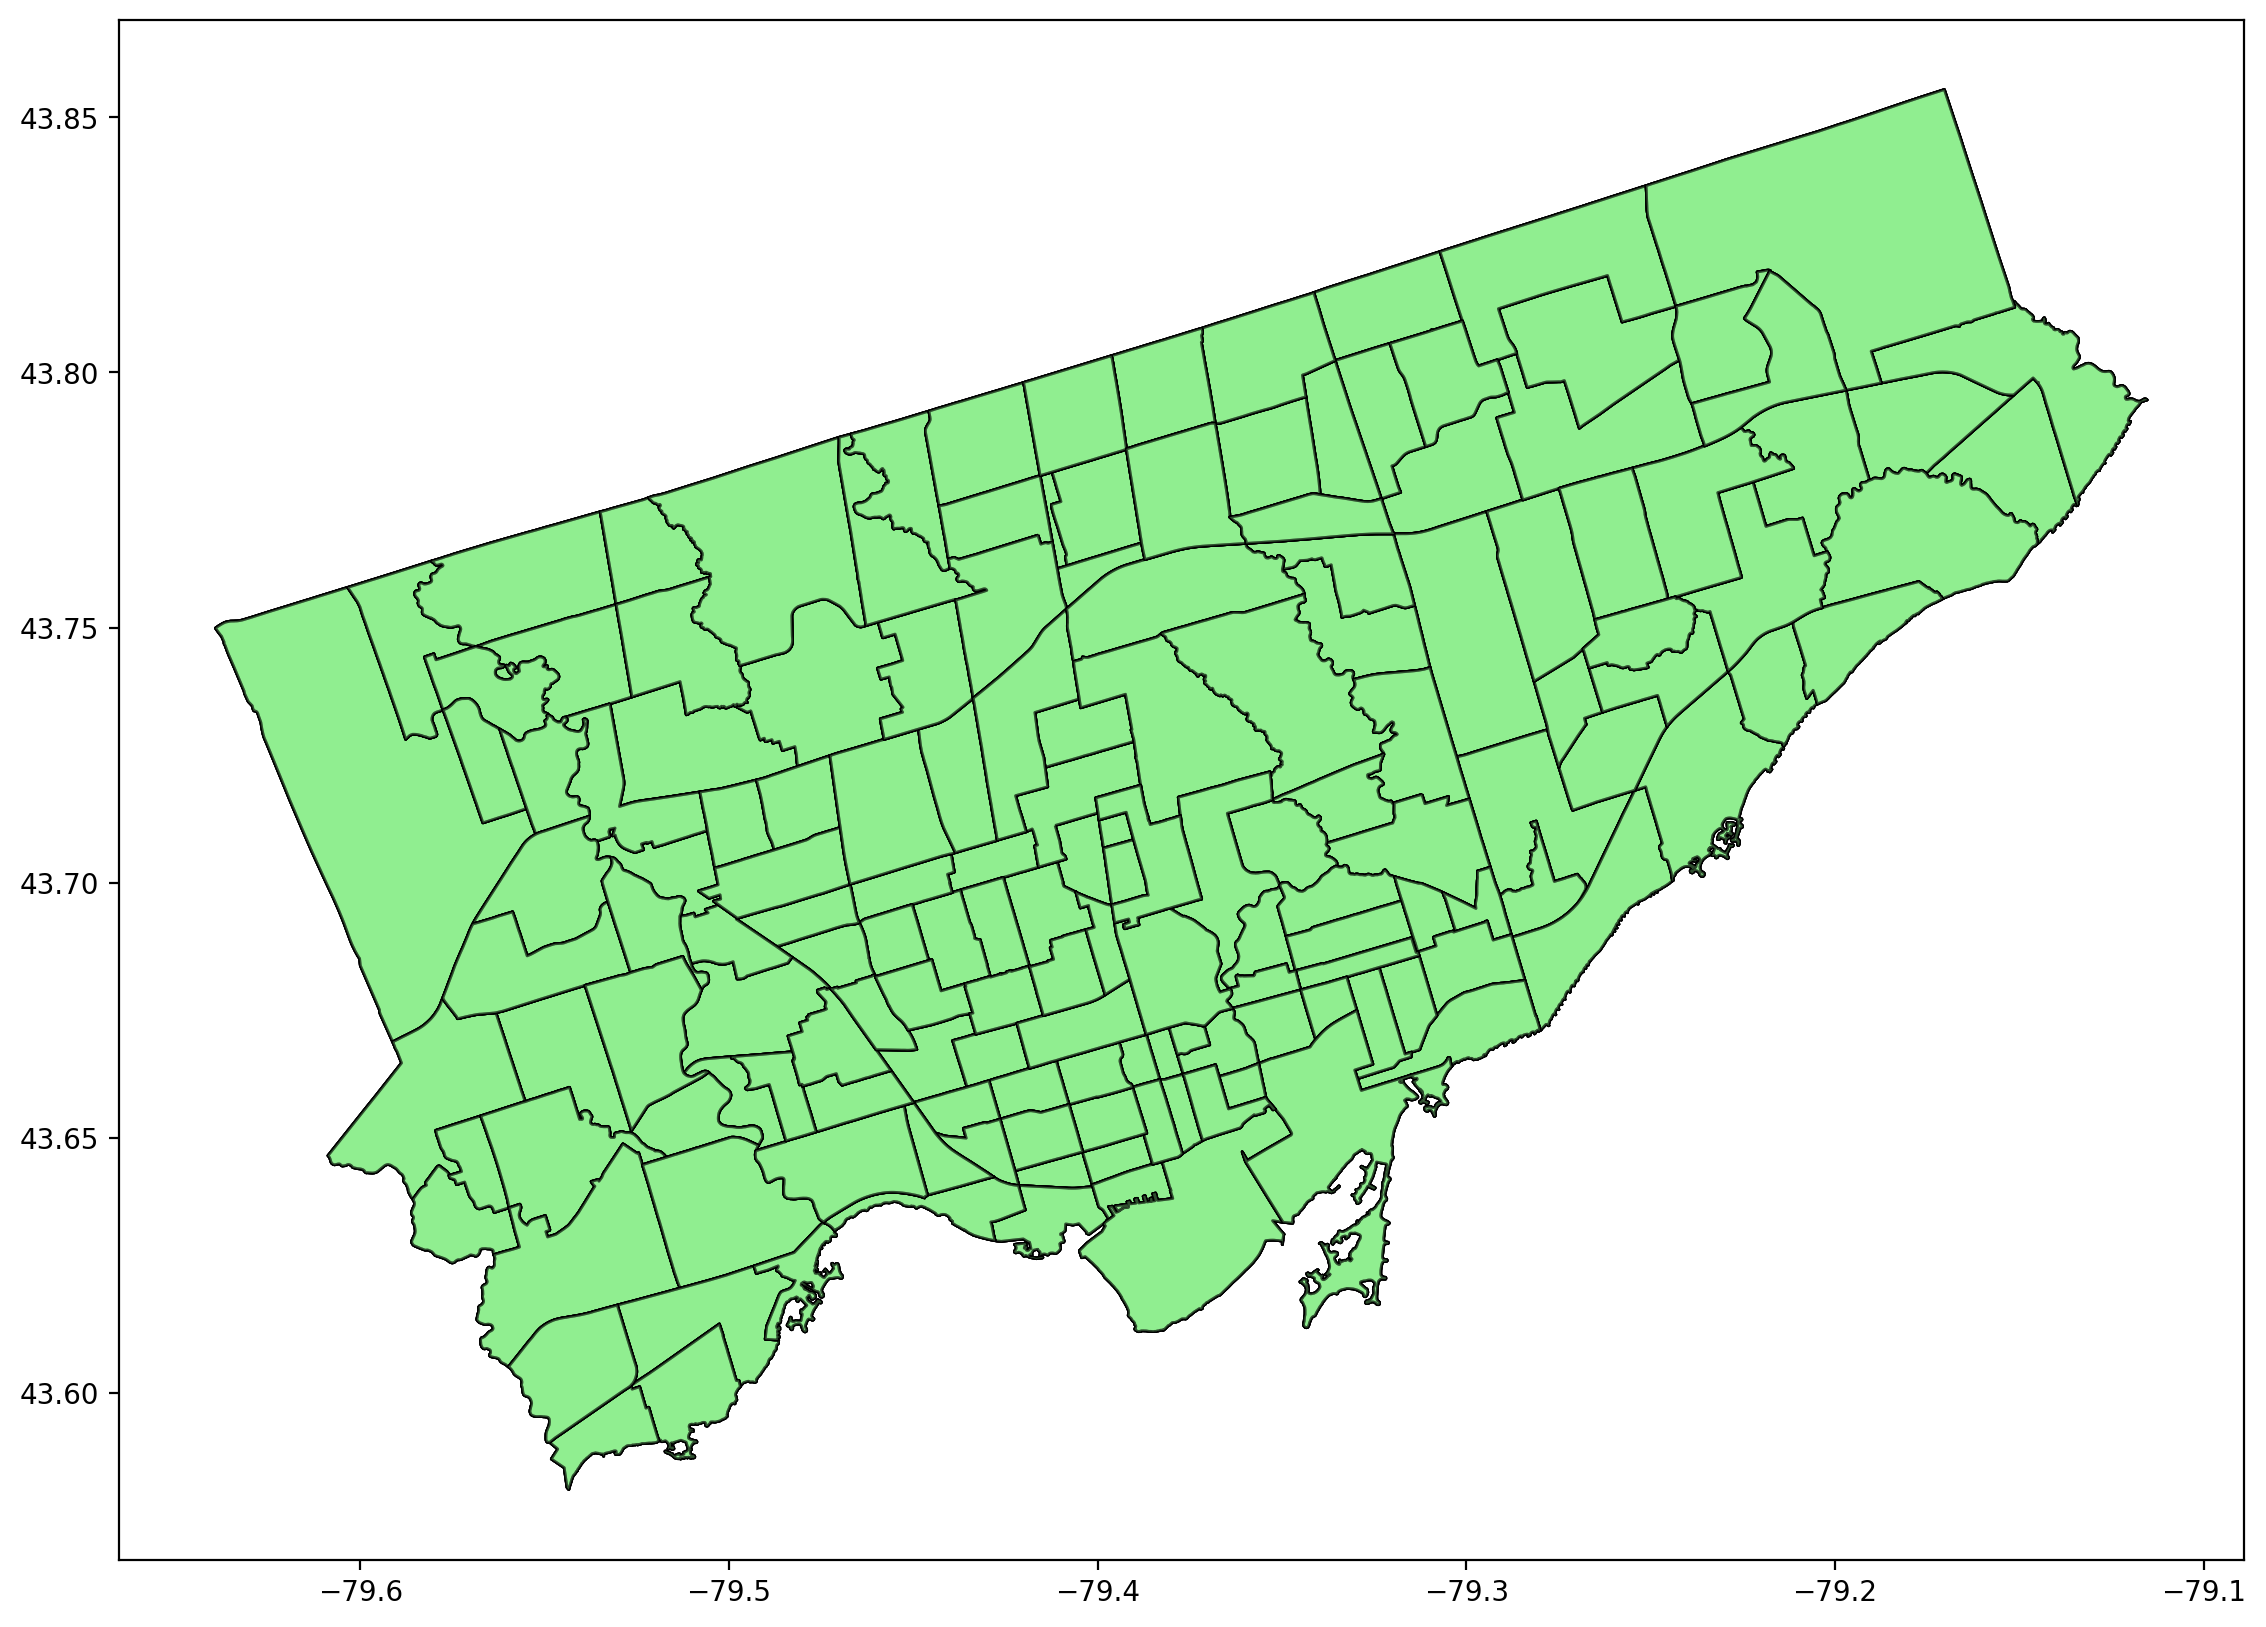

In [114]:
# show that random points generated to impute missing location are within the neighbourhoods
# no red dots should be outside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point.loc[missing_location & ((collision_df.LONGITUDE != 0) & (collision_df.LATITUDE != 0))].plot(ax=ax, color = 'red', markersize = 3)

## NSA is not really 'Not Specified'

<AxesSubplot:>

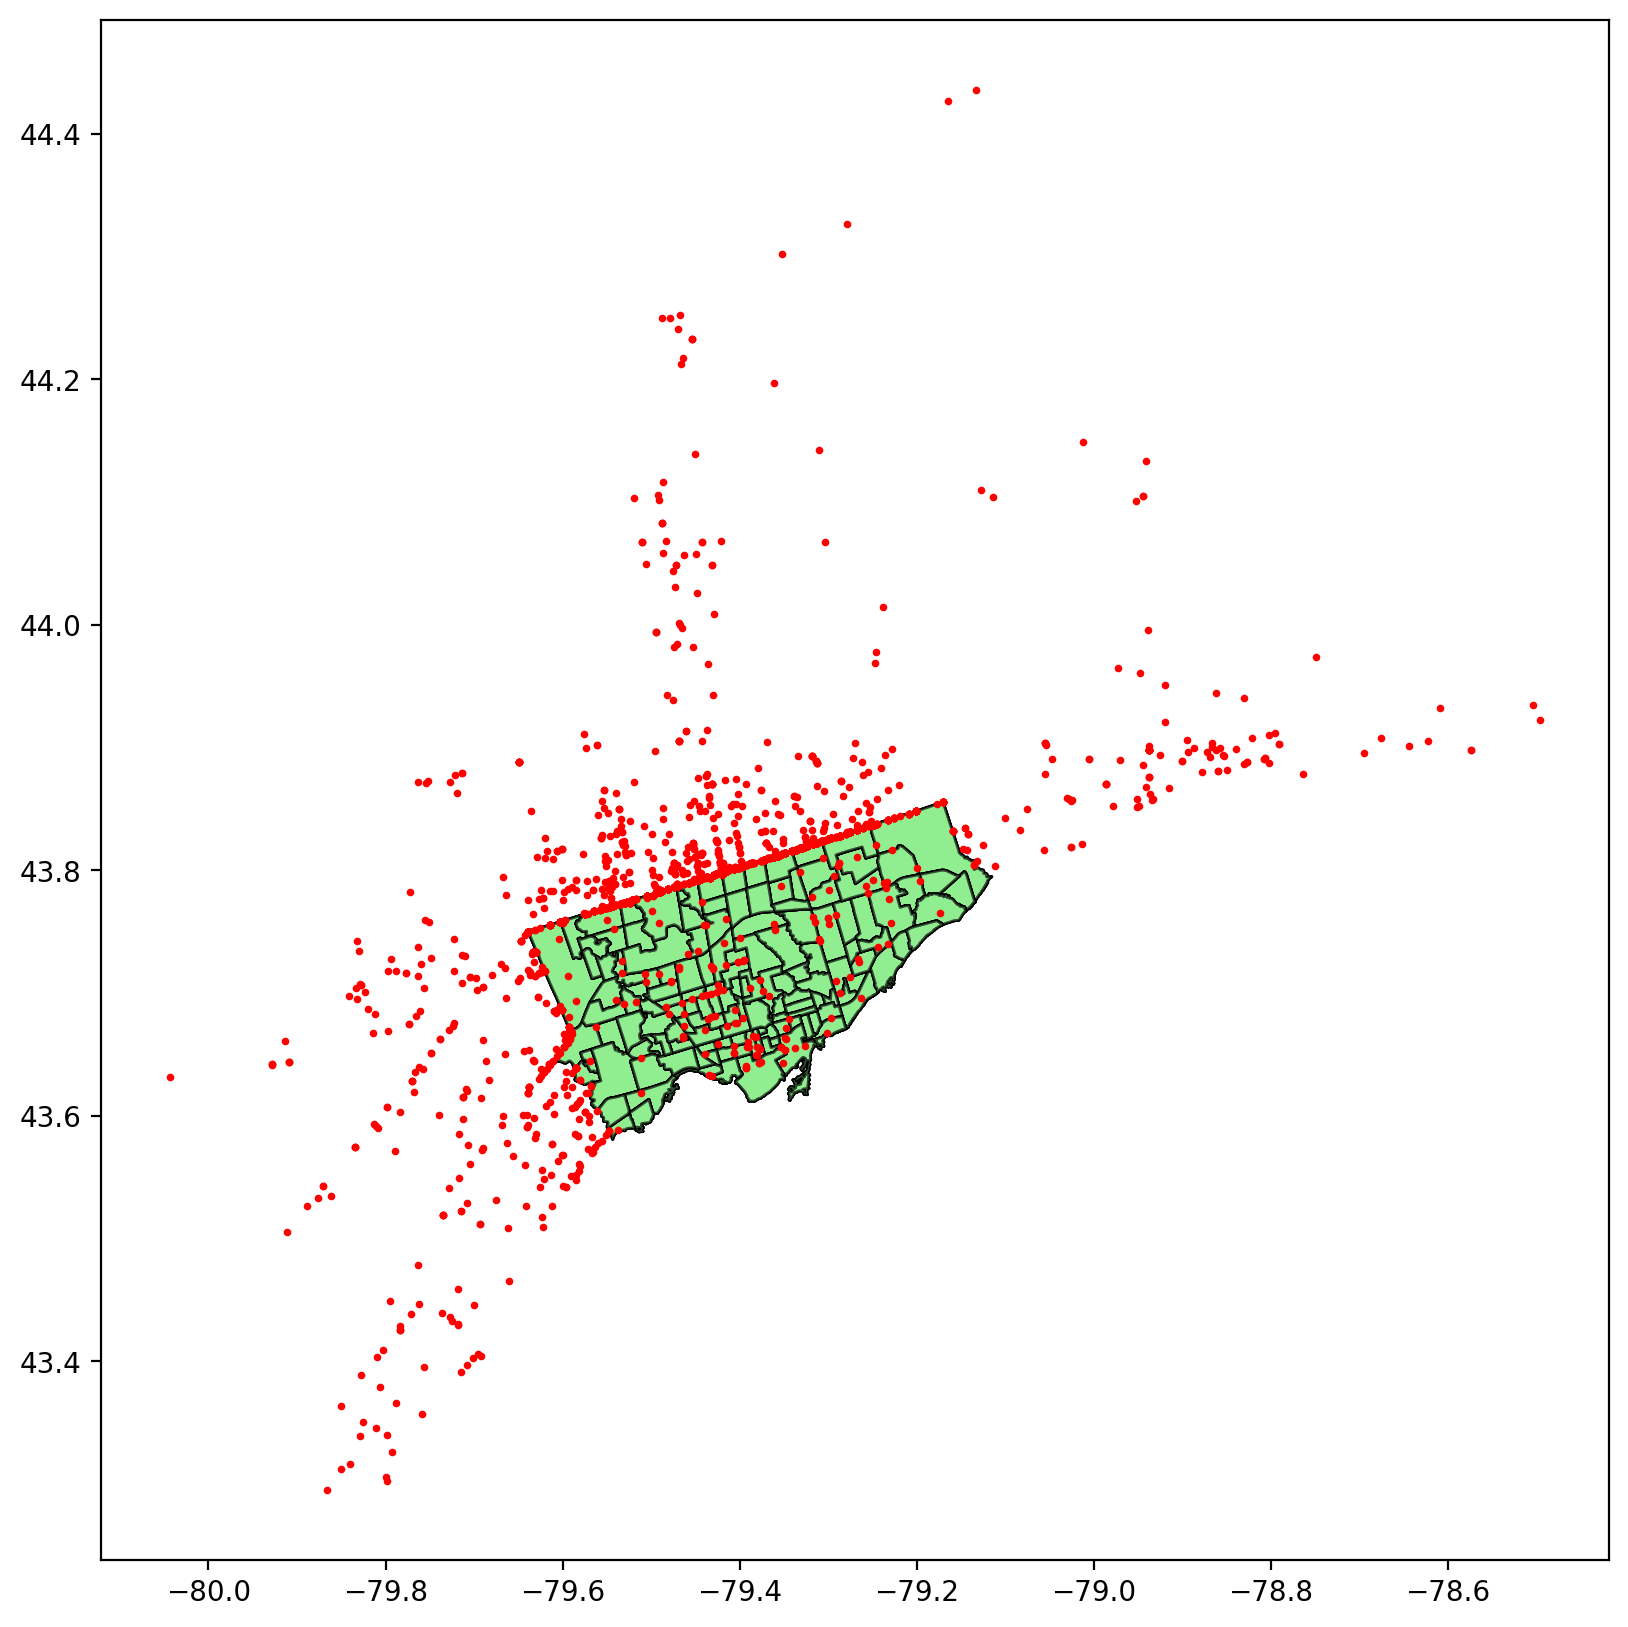

In [127]:
# some locations marked as NSA are actually within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point[collision_point['neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

In [128]:
# get the points contained within the neighbourhood
NSA_within_neighbourhood = gpd.sjoin(collision_point[collision_point['neighbourhood'] == 'NSA'], 
                                    neighbourhoods, 
                                    op='intersects')
collision_point.loc[NSA_within_neighbourhood.index, ['hood_id', 'neighbourhood']] = NSA_within_neighbourhood[['hood_id_right', 'neighbourhood_right']].values

c:\Users\willi\miniconda3\envs\police\lib\site-packages\IPython\core\interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<AxesSubplot:>

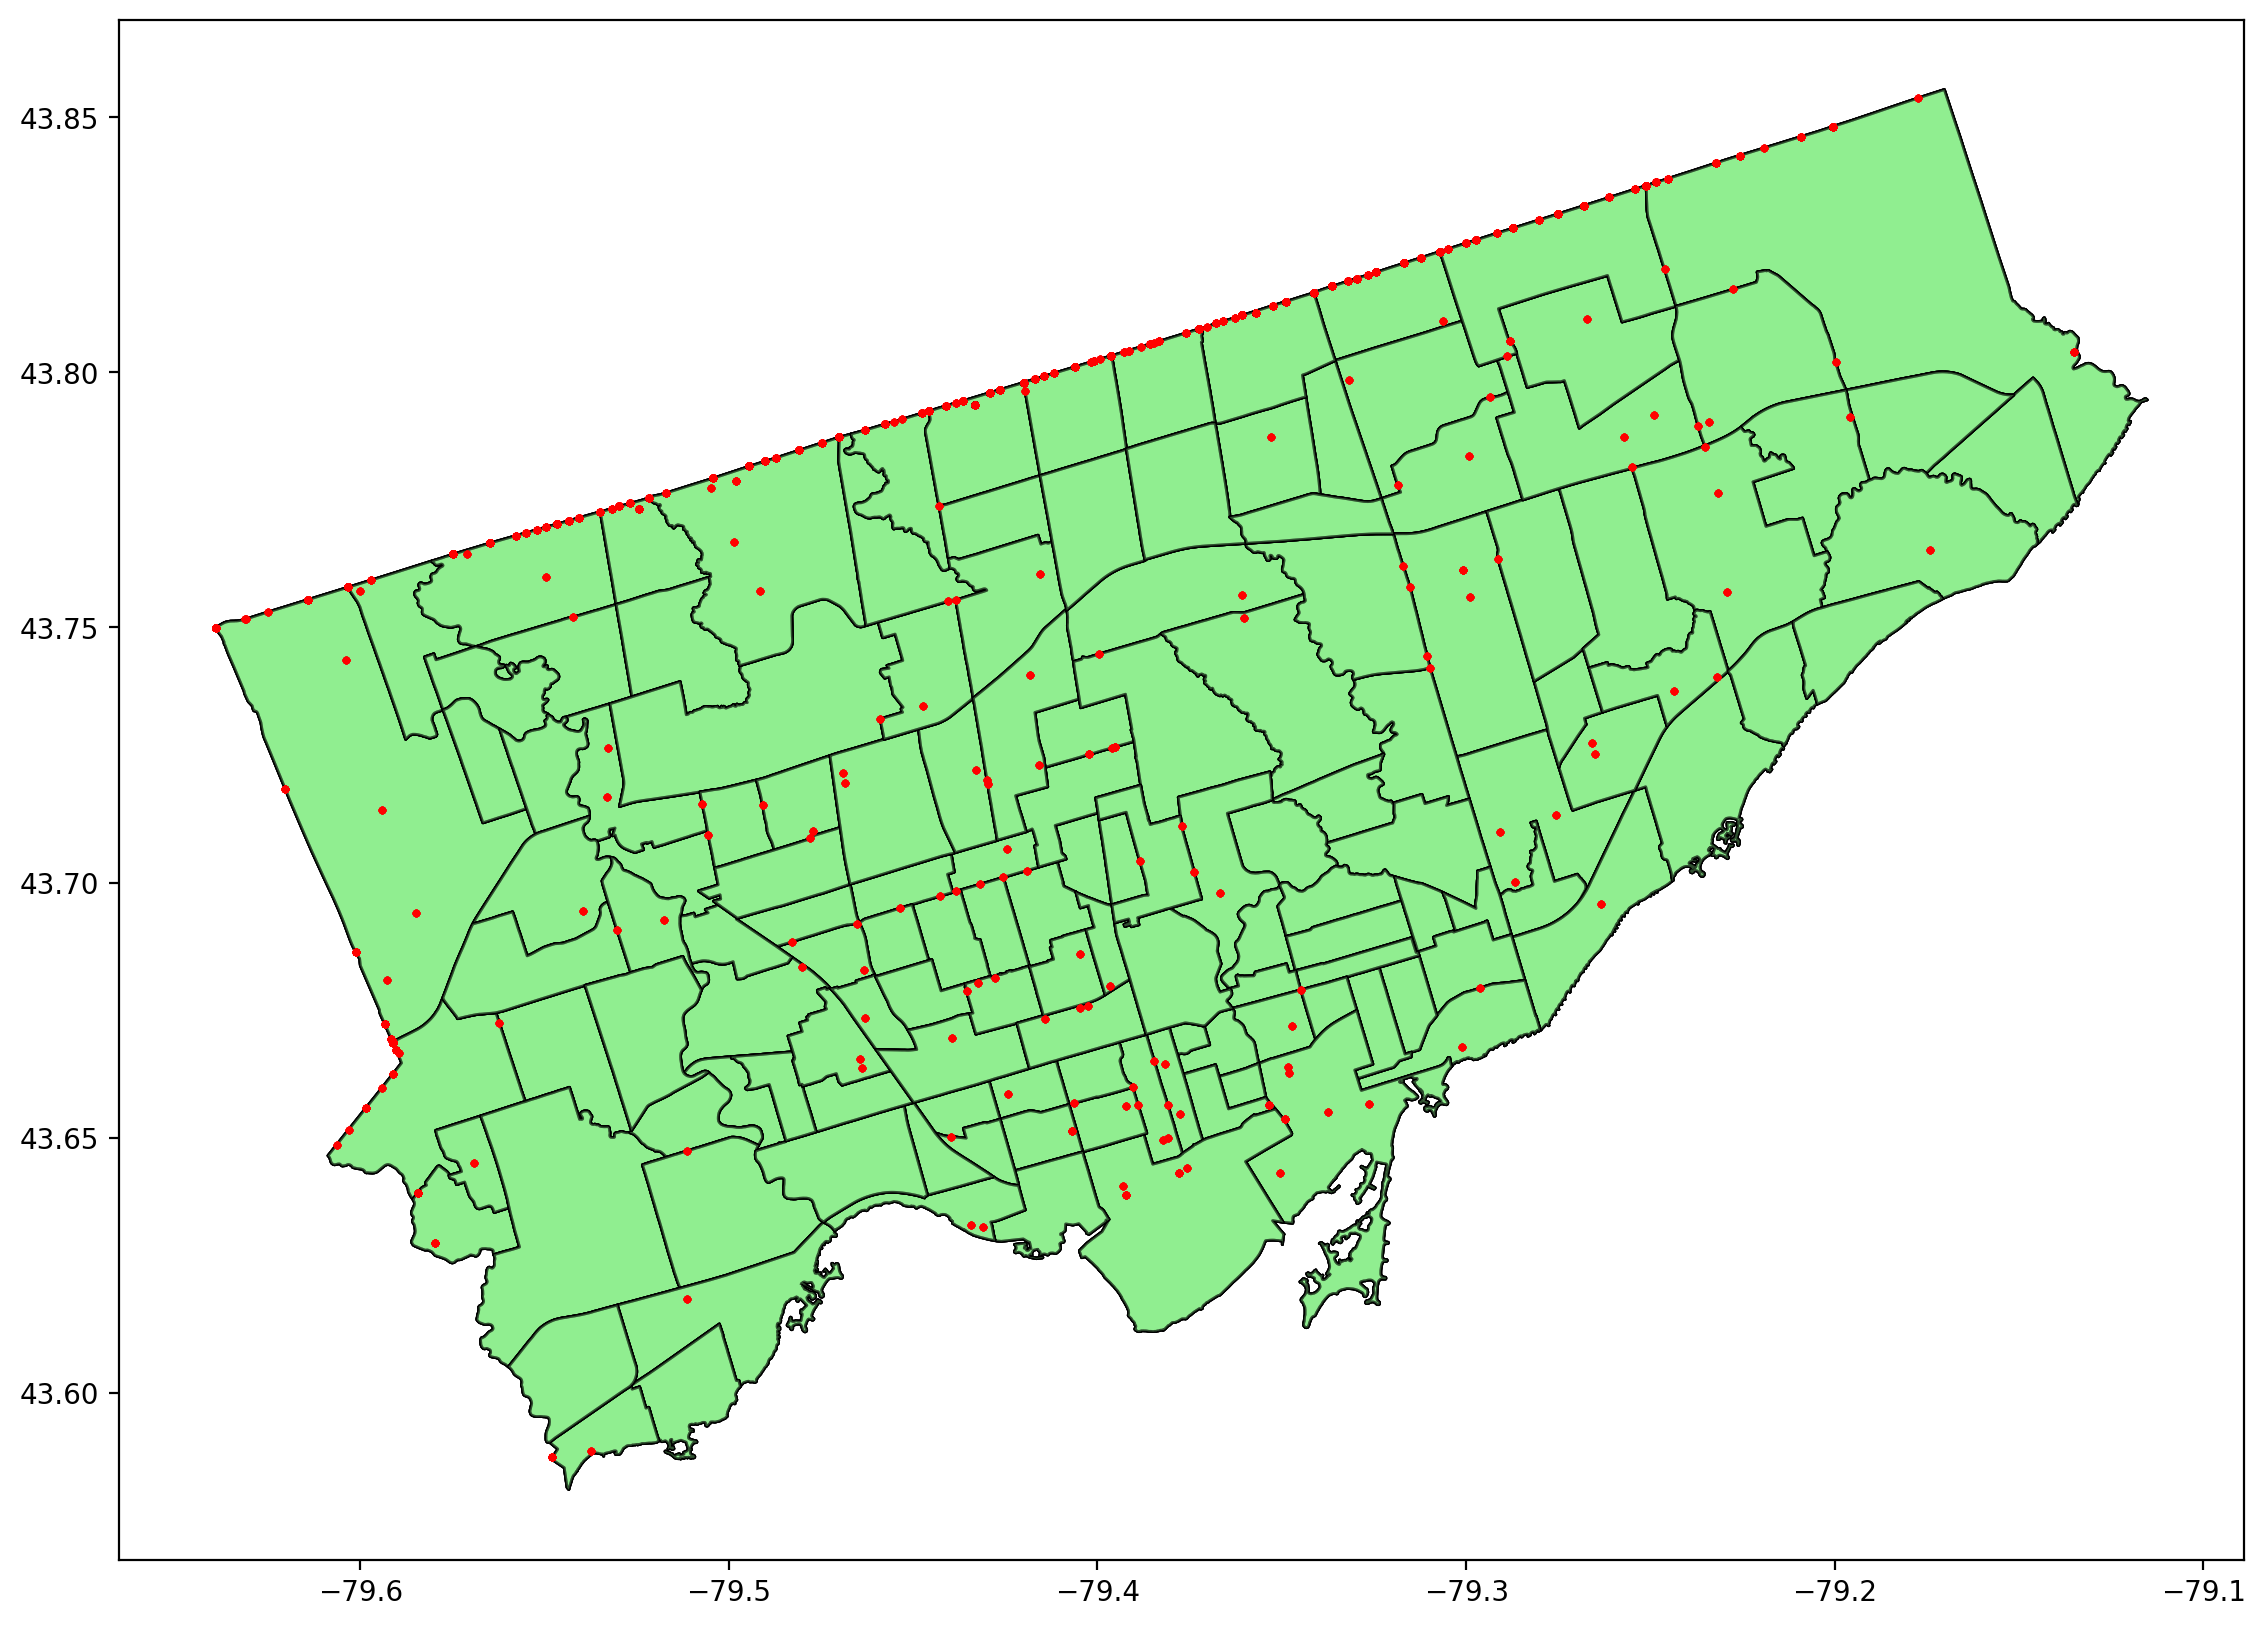

In [129]:
# check that we have correctly isolated only the locations within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point.loc[NSA_within_neighbourhood.index].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

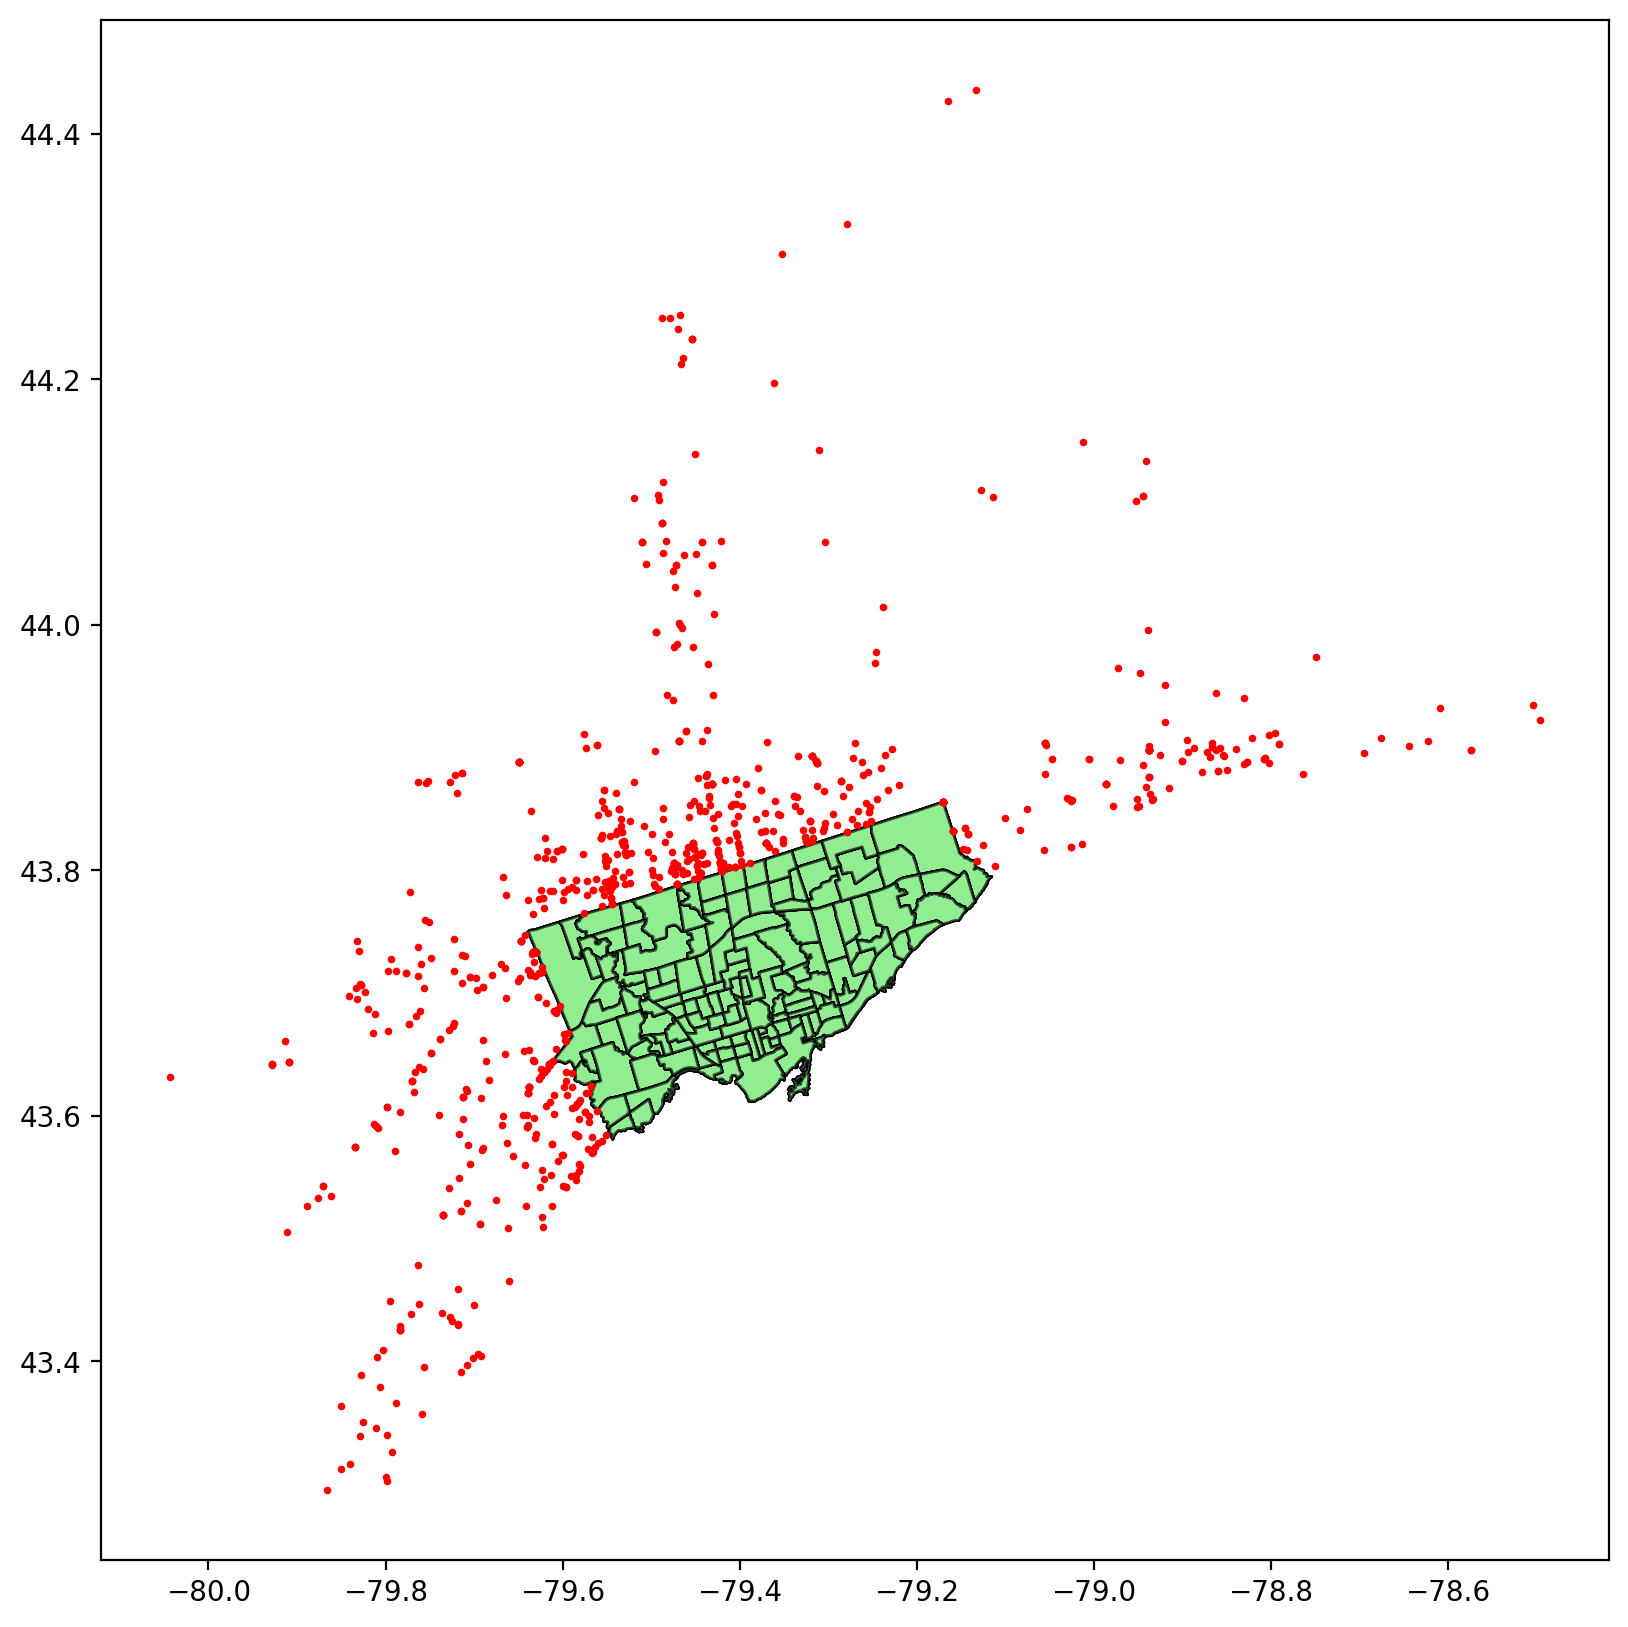

In [130]:
# check that now all the locations with neighbourhood as NSA are outside any out the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point[collision_point['neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

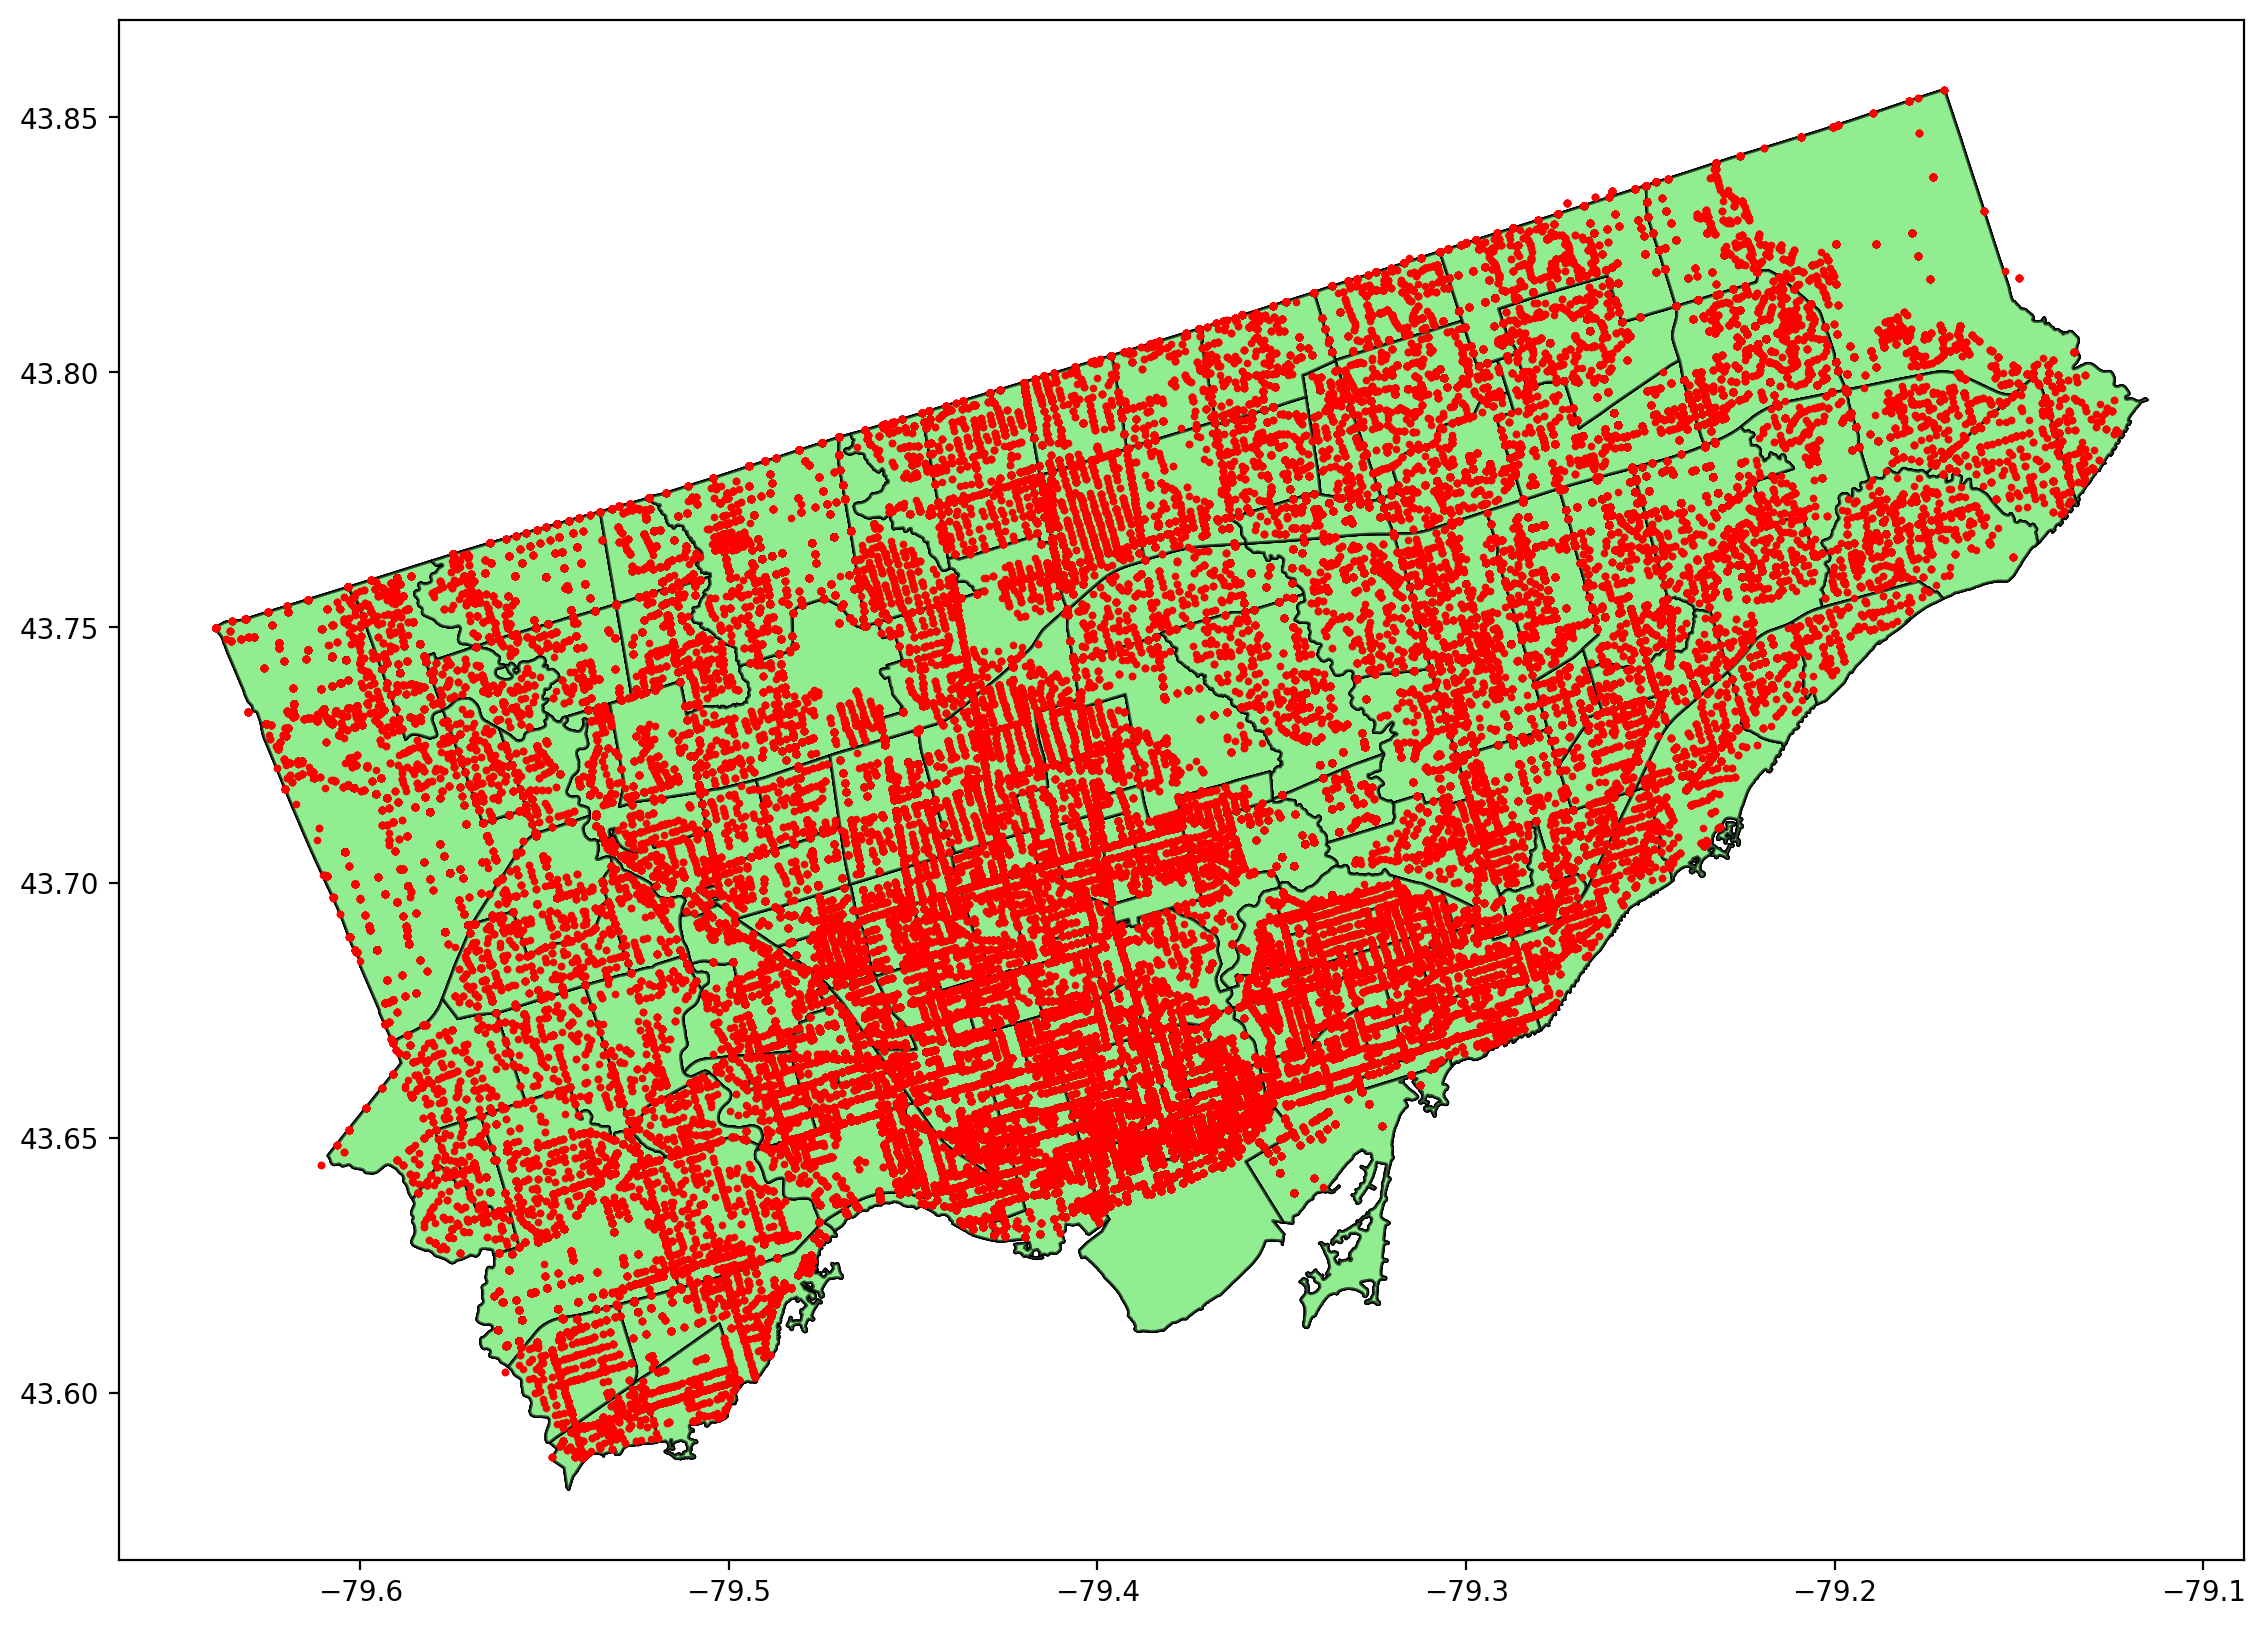

In [131]:
# now all the locations with neighbourhood not as NSA are inside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point[collision_point['neighbourhood'] != 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

# Add Fatal_Collisions

In [132]:
collision_point['fatal_collisions'] = [1 if x != 0 else 0 for x in collision_point['fatalities']]

# Output

In [133]:
collision_point

,occurrence_unique_id,occurrence_date,occurrence_month,occurrence_dayofweek,occurrence_year,occurrence_hour,hood_id,neighbourhood,fatalities,injury_collisions,ftr_collisions,pd_collisions,longitude,latitude,occurrence_day,occurrence_dayofyear,geometry,fatal_collisions
0,GO-20141283080,2014-01-04 22:00:00,January,Saturday,2014,22,58,Old East York,0,0,1,0,-79.336333,43.697612,4,4,POINT (-79.33633 43.69761),0
1,GO-20141384134,2014-01-21 12:00:00,January,Tuesday,2014,12,11,Eringate-Centennial-West Deane,0,0,0,1,-79.561759,43.664797,21,21,POINT (-79.56176 43.66480),0
2,GO-20141283152,2014-01-04 22:00:00,January,Saturday,2014,22,130,Milliken,0,0,1,0,-79.280932,43.828194,4,4,POINT (-79.28093 43.82819),0
3,GO-20141384194,2014-01-21 12:00:00,January,Tuesday,2014,12,27,York University Heights,0,1,0,0,-79.471439,43.767827,21,21,POINT (-79.47144 43.76783),0
4,GO-20141283293,2014-01-04 22:00:00,January,Saturday,2014,22,130,Milliken,0,0,0,1,-79.282497,43.822062,4,4,POINT (-79.28250 43.82206),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452740,GO-202240093,2021-12-15 12:00:00,December,Wednesday,2021,12,26,Downsview-Roding-CFB,0,0,0,1,-79.508595,43.720916,15,349,POINT (-79.50859 43.72092),0
452741,GO-202241692,2021-12-24 01:00:00,December,Friday,2021,1,21,Humber Summit,0,0,0,1,-79.543408,43.770921,24,358,POINT (-79.54341 43.77092),0
452742,GO-20228035384,2021-12-31 16:00:00,December,Friday,2021,16,36,Newtonbrook West,0,1,0,0,-79.420043,43.798000,31,365,POINT (-79.42004 43.79800),0
452743,GO-20228035412,2021-12-30 14:00:00,December,Thursday,2021,14,1,West Humber-Clairville,0,0,0,1,-79.601404,43.730470,30,364,POINT (-79.60140 43.73047),0


In [134]:
collision_point['occurrence_quarter'] = collision_point.occurrence_date.dt.quarter

In [135]:
# output file to clean_data folder
# csv instead of geojson due to size
collision_point.drop(columns=['geometry']).to_csv('../data/processed/collision_select.csv', index=False)

# Aggregate traffic collsions by neighbourhood

<AxesSubplot:xlabel='occurrence_year'>

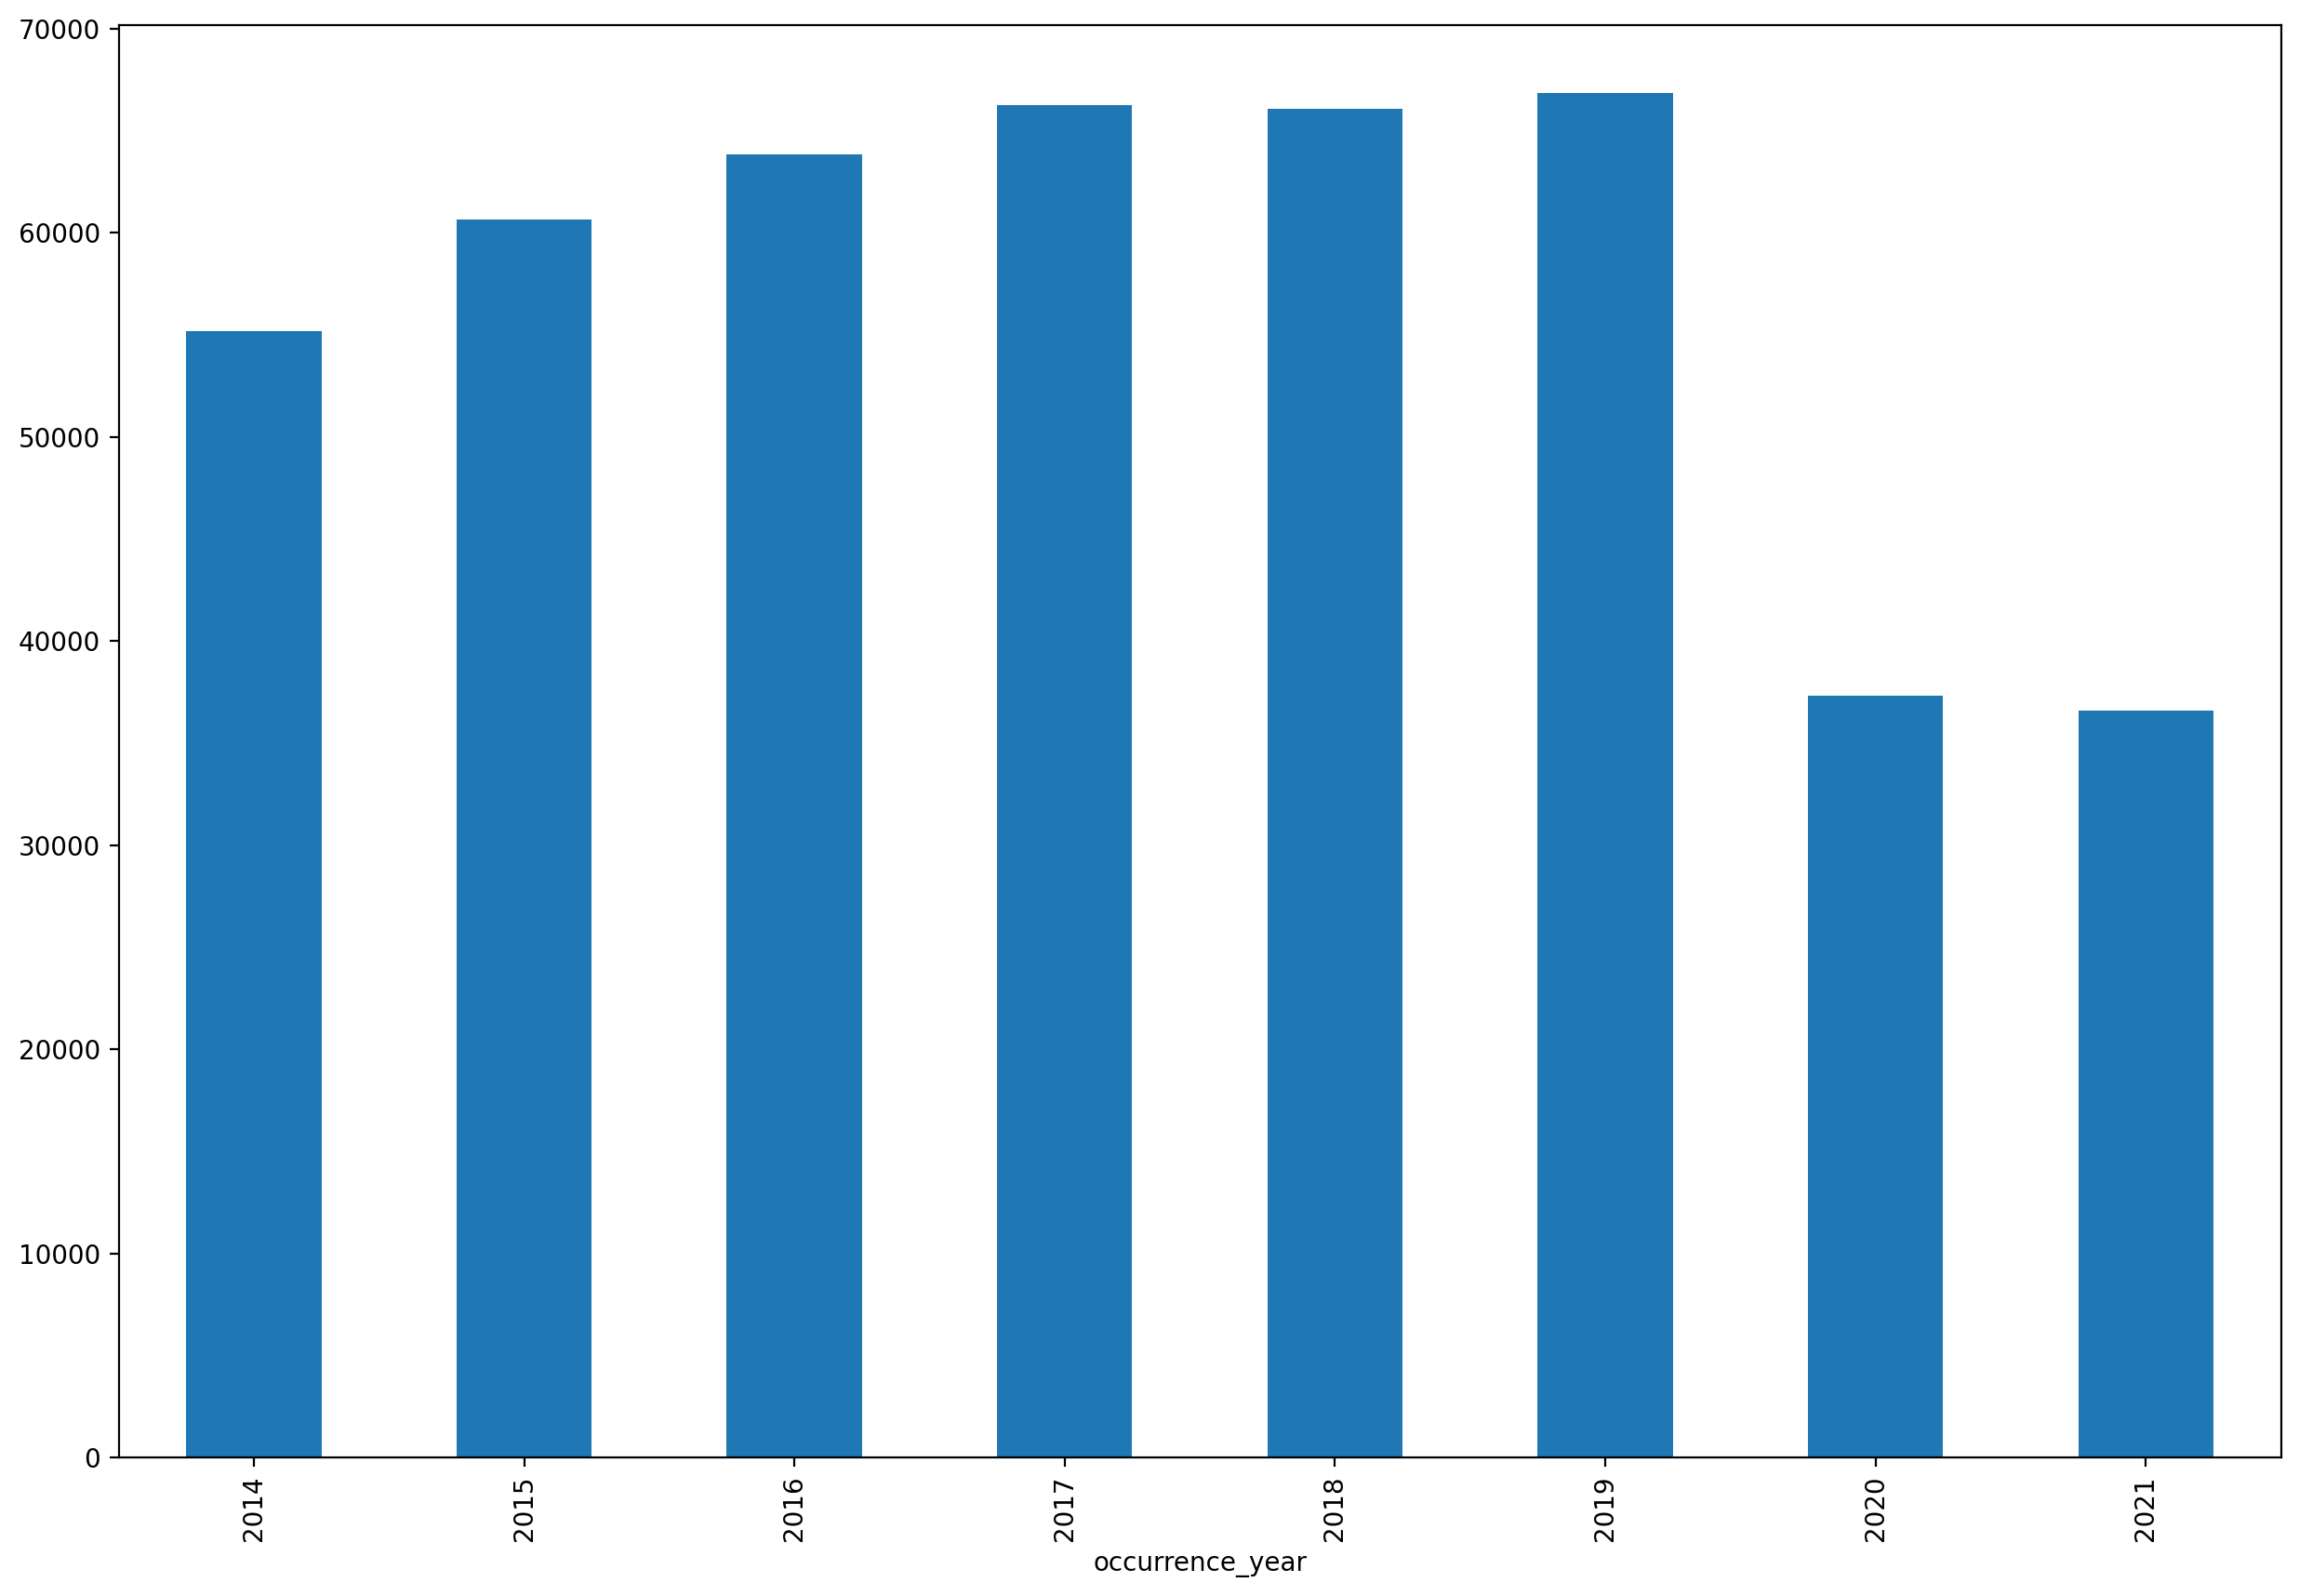

In [136]:
# There is limited data for crimes which happened before 2014
collision_point.groupby("occurrence_year").size().plot(kind="bar")

In [137]:
# filter out data before 2014 and marked as NSA (outside City of Toronto)
collision_groupby = collision_point[collision_point.neighbourhood != "NSA"].\
    groupby(["neighbourhood", "hood_id", "occurrence_year", "occurrence_quarter"]).\
    agg({
        "occurrence_unique_id": "size",
        "fatal_collisions": "sum",
        "injury_collisions": "sum",
        "ftr_collisions": "sum",
        "pd_collisions": "sum"})
    
# unstack to fill those combinations with no record with 0
collision_groupby = collision_groupby.unstack(fill_value=0).stack().reset_index()

collision_groupby.rename(columns={"occurrence_unique_id": "collision"}, inplace=True)
collision_groupby = collision_groupby.melt(id_vars=["neighbourhood", "hood_id", "occurrence_year", "occurrence_quarter"],
                                           var_name="collision_type",
                                           value_name="count")
collision_groupby

,neighbourhood,hood_id,occurrence_year,occurrence_quarter,collision_type,count
0,Agincourt North,129,2014,1,collision,145
1,Agincourt North,129,2014,2,collision,102
2,Agincourt North,129,2014,3,collision,114
3,Agincourt North,129,2014,4,collision,122
4,Agincourt North,129,2015,1,collision,155
...,...,...,...,...,...,...
22395,Yorkdale-Glen Park,31,2020,4,pd_collisions,84
22396,Yorkdale-Glen Park,31,2021,1,pd_collisions,60
22397,Yorkdale-Glen Park,31,2021,2,pd_collisions,75
22398,Yorkdale-Glen Park,31,2021,3,pd_collisions,126


In [138]:
collision_groupby.occurrence_year.unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype=int64)

## Add neighbourhood information

In [141]:
neighbourhoods_final = neighbourhoods[['hood_id', 'occurrence_year', 'area', 'population']]
neighbourhoods_final

,hood_id,occurrence_year,area,population
0,1,2014,30.145103,34745
1,1,2015,30.145103,34557
2,1,2016,30.145103,34418
3,1,2017,30.145103,35085
4,1,2018,30.145103,35772
...,...,...,...,...
1255,99,2018,3.088880,17633
1256,99,2019,3.088880,17812
1257,99,2020,3.088880,17972
1258,99,2021,3.088880,18261


In [142]:
collision_groupby

,neighbourhood,hood_id,occurrence_year,occurrence_quarter,collision_type,count
0,Agincourt North,129,2014,1,collision,145
1,Agincourt North,129,2014,2,collision,102
2,Agincourt North,129,2014,3,collision,114
3,Agincourt North,129,2014,4,collision,122
4,Agincourt North,129,2015,1,collision,155
...,...,...,...,...,...,...
22395,Yorkdale-Glen Park,31,2020,4,pd_collisions,84
22396,Yorkdale-Glen Park,31,2021,1,pd_collisions,60
22397,Yorkdale-Glen Park,31,2021,2,pd_collisions,75
22398,Yorkdale-Glen Park,31,2021,3,pd_collisions,126


In [143]:
collision_merge = neighbourhoods_final.merge(collision_groupby, how='inner', on=['hood_id', 'occurrence_year'])
collision_merge

,hood_id,occurrence_year,area,population,neighbourhood,occurrence_quarter,collision_type,count
0,1,2014,30.145103,34745,West Humber-Clairville,1,collision,353
1,1,2014,30.145103,34745,West Humber-Clairville,2,collision,303
2,1,2014,30.145103,34745,West Humber-Clairville,3,collision,322
3,1,2014,30.145103,34745,West Humber-Clairville,4,collision,312
4,1,2014,30.145103,34745,West Humber-Clairville,1,fatal_collisions,0
...,...,...,...,...,...,...,...,...
22395,99,2021,3.088880,18261,Mount Pleasant East,4,ftr_collisions,9
22396,99,2021,3.088880,18261,Mount Pleasant East,1,pd_collisions,48
22397,99,2021,3.088880,18261,Mount Pleasant East,2,pd_collisions,36
22398,99,2021,3.088880,18261,Mount Pleasant East,3,pd_collisions,54


In [144]:
collision_merge.isna().sum()

hood_id               0
occurrence_year       0
area                  0
population            0
neighbourhood         0
occurrence_quarter    0
collision_type        0
count                 0
dtype: int64

## add rate / density

In [145]:
# rate: number of collisions per 100k people
collision_merge['rate'] = collision_merge['count'] / collision_merge['population'] * 10**5
# density: number of collisions per 1km^2
collision_merge['density'] = collision_merge['count'] / collision_merge['area']

In [146]:
collision_merge

,hood_id,occurrence_year,area,population,neighbourhood,occurrence_quarter,collision_type,count,rate,density
0,1,2014,30.145103,34745,West Humber-Clairville,1,collision,353,1015.973521,11.710028
1,1,2014,30.145103,34745,West Humber-Clairville,2,collision,303,872.067923,10.051384
2,1,2014,30.145103,34745,West Humber-Clairville,3,collision,322,926.752051,10.681669
3,1,2014,30.145103,34745,West Humber-Clairville,4,collision,312,897.970931,10.349940
4,1,2014,30.145103,34745,West Humber-Clairville,1,fatal_collisions,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
22395,99,2021,3.088880,18261,Mount Pleasant East,4,ftr_collisions,9,49.285362,2.913678
22396,99,2021,3.088880,18261,Mount Pleasant East,1,pd_collisions,48,262.855265,15.539613
22397,99,2021,3.088880,18261,Mount Pleasant East,2,pd_collisions,36,197.141449,11.654710
22398,99,2021,3.088880,18261,Mount Pleasant East,3,pd_collisions,54,295.712173,17.482065


In [148]:
collision_melt = collision_merge.melt(id_vars=['neighbourhood', 'hood_id', 'occurrence_year', 'occurrence_quarter', 'area', 'population', 'collision_type'],
                                      value_vars=['count', 'rate', 'density'],
                                      var_name='type',
                                      value_name='value')
collision_melt

,neighbourhood,hood_id,occurrence_year,occurrence_quarter,area,population,collision_type,type,value
0,West Humber-Clairville,1,2014,1,30.145103,34745,collision,count,353.000000
1,West Humber-Clairville,1,2014,2,30.145103,34745,collision,count,303.000000
2,West Humber-Clairville,1,2014,3,30.145103,34745,collision,count,322.000000
3,West Humber-Clairville,1,2014,4,30.145103,34745,collision,count,312.000000
4,West Humber-Clairville,1,2014,1,30.145103,34745,fatal_collisions,count,0.000000
...,...,...,...,...,...,...,...,...,...
67195,Mount Pleasant East,99,2021,4,3.088880,18261,ftr_collisions,density,2.913678
67196,Mount Pleasant East,99,2021,1,3.088880,18261,pd_collisions,density,15.539613
67197,Mount Pleasant East,99,2021,2,3.088880,18261,pd_collisions,density,11.654710
67198,Mount Pleasant East,99,2021,3,3.088880,18261,pd_collisions,density,17.482065


In [161]:
collision_melt.to_csv('../data/processed/neighbourhoods_collision.csv', index=False)